# makemore part 5: Building a WaveNet

## What is makemore?

Makemore "makes more" of things that you give it. Example uses `names.txt` and makemore learns to make names

Under the hood, makemore is a character-level language model: it treats each line as sequences of individual characters. Model sequence of characters and try to predict next characters in a sequence.

This class will look at 
1. Bigram (one character simply predicts a next one with a lookup table of counts)
2. ~~Bag of Words~~
   1. The table explodes! We'll skip
3. **Multilayer Perceptron**
4. Recurrent Neural Network
5. GRU
6. Transformers

Will build a transformer equivalent to GPT-2, at the level of characters

## Agenda
Characters
Words
Images

## WaveNet

In this lecture, we will manually work through WaveNet because we have been compressing down to a single hidden layer with only a few characters. We will end up making WaveNet which is a much more complicated architecture.


---

## External Resources

### Lesson

[Makemore part 5](https://www.youtube.com/watch?v=t3YJ5hKiMQ0)


___

## Import necessary libraries

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

---

In [2]:
# read in all the words
names_data = '../../data/raw/names.txt'

words = open(names_data, 'r').read().splitlines()

print(len(words))
print(max(len(w) for w in words))
print(words[:10])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i  in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words 
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset but via a function instead
block_size = 8 # context length: how many characters do we take to predict the next one?
    
def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])        #80%
Xdev, Ydev = build_dataset(words[n1:n2])    #10%
Xte, Yte = build_dataset(words[n2:])        #10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [7]:
# Let's train a deeper network

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)                 # batch mean
            xvar = x.var(dim, keepdim=True, unbiased=True)    # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / (torch.sqrt(xvar + self.eps))  # normalizing to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [8]:
torch.manual_seed(42); #seed rng for reproducibility

In [9]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# this is before PyTorchifiying the code
# C = torch.randn((vocab_size, n_embd))

layers = [
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

model = Sequential(layers)

# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # make last layer less confident

# this is before PyTorchifiying the code
# parameters = [C] + [p for layer in layers for p in layer.parameters()]

parameters = model.parameters()

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

170897


In [10]:
# let's look at a batch of just 4 examples
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  1,  2, 18,  9],
        [ 0,  0,  0, 22,  9,  3, 20, 15],
        [ 0,  0,  1, 14,  7,  5, 12,  5],
        [19, 15,  3,  8,  9, 11,  1,  9]])

In [11]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [12]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 200])

In [13]:
# output of Embedding layer
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [14]:
# output of Flatten layer
model.layers[1].out.shape

torch.Size([4, 4, 20])

In [15]:
# output of Linear layer
model.layers[2].out.shape

torch.Size([4, 4, 200])

In [16]:
e = torch.randn(4, 8, 10)

# goal: we want this to be (4,4,20) where consecutive 10-d vectors get concatenated
explicit = torch.cat([e[:,::2,:], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [17]:
(e.view(4, 4, 20) == explicit).all()

tensor(True)

In [18]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    # this is before PyTorchifiying the code
    # emb = C[Xb] # embed the characters into vectors
    # x = emb.view(emb.shape[0], -1) # concatenate the vectors
    # x = Xb
    # for layer in layers:
    #     x = layer(x)
    logits = model(Xb)
    # loss = F.cross_entropy(x, Yb)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0 /  200000: 3.2985
  10000 /  200000: 2.2368
  20000 /  200000: 2.1199
  30000 /  200000: 2.0170
  40000 /  200000: 2.0810
  50000 /  200000: 2.6077
  60000 /  200000: 1.9229
  70000 /  200000: 2.0581
  80000 /  200000: 2.1431
  90000 /  200000: 2.1936
 100000 /  200000: 1.7581
 110000 /  200000: 1.8759
 120000 /  200000: 2.0456
 130000 /  200000: 1.7273
 140000 /  200000: 1.7293
 150000 /  200000: 1.7520
 160000 /  200000: 1.7484
 170000 /  200000: 1.5953
 180000 /  200000: 1.9984
 190000 /  200000: 1.6403


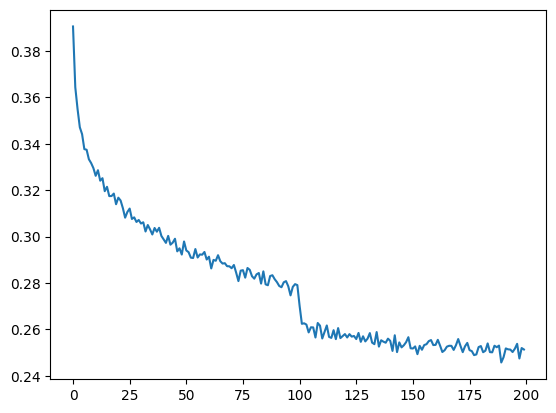

In [19]:
# plt.plot(lossi);
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1));

In [20]:
# put layers into eval mode (needed for BatchNorm especially)
for layer in model.layers:
    layer.training = False

In [21]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    # this is before PyTorchifiying the code
    # emb = C[x] # (N, block_size, n_embd)
    # x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    # for layer in layers:
    #     x = layer(x)
    
    logits = model(x)
    # loss = F.cross_entropy(x, y)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [22]:
split_loss('train')
split_loss('val')

train 1.7594281435012817
val 1.9881688356399536


In [23]:
# sample from the model

for _ in range(20):
    out = []
    context = [0] * block_size #initialize with all ...
    while True:
        # forward pass the neural net
        # this is before PyTorch-ifying the code
        # emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        # x = emb.view(emb.shape[0], -1)
        # for layer in layers:
        #     x = layer(x)
        # logits = x

        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) #decode and print the generated word

keen.
moster.
arelie.
semmiyah.
aline.
keitlingo.
corvan.
sidneva.
mahir.
kensleigh.
jdelle.
kaliel.
finlee.
ramsa.
asato.
keelyn.
kailon.
wren.
judiella.
athiel.


Four takeaways:
1. More steps towards PyTorchifying our code
   1. Now switching to use torch.nn directly
2. Understand some of the development process for building neural nets
   1. Lots of looking at pytorch documentation
3. Lots of trying to get the shapes work a
   1. Prototype in Notebooks before moving to actual code
4. Will need to set up an evaluation harness and do hyperparameter searches

Can try to beat the loss, try reading the WaveNet paper and using their suggestions for improving loss